[//]: #![erdos-logo](risecamp/erdos-pylot-risecamp-logo.png)
<img src="risecamp/erdos-pylot-risecamp-logo.png" alt="erdos-logo" style="width: 800px;"/>

<font color="red"><b>TODO</b></font>: Give an intro of what ERDOS and Pylot is.

# Architecture of an Autonomous Vehicle

[//]: #![Pylotpipeline](./doc/source/images/pylot.png)
<img src="doc/source/images/pylot.png" alt="Pylot Pipeline" style="width: 800px;"/>

An autonomous vehicle (AV) is typically equipped with multiple instances of sensor including cameras and LiDARs that operate at different frequencies and generate approximately 1GB/s of data.

A state-of-the-art AV pipeline comprises of five modules, each implemented using several components:
1. __Perception__: Recognizes the scene by detecting and classifying objects.
2. __Localization__: Provides the location of the vehicle with decimeter-level accuracy.
3. __Prediction__: Estimates how other agents would move in the environment.
4. __Planning__: Generates trajectories for the AV to follow.
5. __Control__: Physically operates the AV.

## Tutorial Overview

In this set of tutorials, we will focus on the __*perception*__ and the __*planning*__ modules of the vehicle.

[Exercise 1](#exercise1) implements an object detector for the __*perception*__ module of an AV pipeline, and drives it around in a simulated environment.

[Exercise 2](#exercise2) <font color="red"><b>TODO</b></font>: Fill.

<a id='exercise1'></a> 
## Exercise 1: Developing a Perception component
![perception](risecamp/perception-crop.gif)

__Goal__: Get started with the [ERDOS](https://github.com/erdos-project/erdos) API by developing an object detector for an autonomous vehicle, and driving it in the [CARLA simulator](https://carla.org) using [Pylot](https://github.com/erdos-project/pylot).

ERDOS models the AV pipeline as a directed dataflow graph where developers implement the components of the pipeline as __*operators*__ that communicate with each other through typed __*streams*__. Operators can request callbacks upon receipt of messages on a stream, and send the computed results to other operators via a different stream. For example, an __*object detector*__ component runs an object detection model on incoming messages from a camera stream and sends the detected objects to the __*prediction*__ module.

### Part 1: Structure of an ERDOS Operator
An ERDOS Operator is a Python `class` which receives the input and output streams as part of its `__init__` function. 

```python
import erdos

class Operator(erdos.Operator):
    def __init__(self, input_stream_1, input_stream_2, ..., output_stream_1, output_stream_2):
        pass
```

__*[Part 2](#exercise1part2) describes how the input and output streams are connected to other components*__


Developers can request callbacks on the receipt of messages on a stream by registering the callback using the `add_callback` method.

```python
class Operator(erdos.Operator):
    def __init__(self, input_stream_1, input_stream_2, ..., output_stream_1, output_stream_2):
        input_stream_1.add_callback(self.on_message)

    def on_message(self, message):
        # Work on the message here.
```

To allow a callback to send data on an output stream, developers can pass the required output streams to the `add_callback` method. Inside the callback, developers can call the `send` method on an output stream to send the message to other operators.

```python
class Operator(erdos.Operator):
    def __init__(self, input_stream_1, input_stream_2, ..., output_stream_1, output_stream_2):
        input_stream_1.add_callback(on_message, [output_stream_1, output_stream_2])

    def on_message(self, message, output_stream_1, output_stream_2):
        # Work on the message and send the output to any of the output streams.
        result = ...
        output_stream_1.send(result)
```

We are now going to use the ERDOS API to implement an __*object detection*__ component. The following cell provides the skeleton implementation for an `ObjectDetectionOperator`. In order to get it to detect incoming objects, you have to complete the following tasks:
1. Register the `on_message` method to be invoked upon receipt of messages on the `camera_stream`. (Don't forget to provide the `detected_objects_stream` to the callback!)
2. Inside the callback, invoke the `detect_objects` method on the incoming message, and `send` the results on the `detected_objects_stream`.

In [1]:
import erdos

from pylot.risecamp_utils import load_model, infer_from_model

# The path where the checkpoint of the model is stored.
MODEL_PATH = "dependencies/models/obstacle_detection/faster-rcnn/frozen_inference_graph.pb"

class ObjectDetectionOperator(erdos.Operator):
    """Detect objects using images received on the camera stream."""
    def __init__(self, camera_stream, detected_objects_stream):
        # TODO (1): Register the `self.on_message` method here! 
        # TODO (2): Provide the `detected_objects_stream` to the method.
        camera_stream.add_callback(self.on_message, [detected_objects_stream])
        
        # Model loading, don't change.
        self.model = load_model(MODEL_PATH)
        
    def on_message(self, message, detected_objects_stream):
        """ Receives a message with the camera frame and runs a model on the frame. """
        # TODO (3): Invoke the `detect_objects` method on the `message`, 
        #           and save results into `detected_objects`.
        detected_objects = self.detect_objects(message)
    
        # TODO (4): Send `detected_objects` to the other operators, by
        #           invoking `send` on `detected_objects_stream` and 
        #           passing the `detected_objects` as an argument.
        detected_objects_stream.send(detected_objects)
        
        
    # Don't change the code below.
    def detect_objects(self, message):
        return infer_from_model(self.model, message)
    
    @staticmethod
    def connect(camera_stream):
        detected_objects_stream = erdos.WriteStream()
        return [detected_objects_stream]
    
# Validation code (don't change!)
from pylot.risecamp_utils import validate_problem_1
fail, err = validate_problem_1(ObjectDetectionOperator)
if fail:
    print("\x1b[31mFAILURE:\x1b[0m {}".format(err))
else:
    print("\x1b[32mSUCCESS!\x1b[0m {}".format(err))

SUCCESS! 


<a id='exercise1part2'></a> 
### Part 2: Connecting Operators together!

Now that we have our `ObjectDetectionOperator` ready to process camera images, we need to connect it to a camera stream and process input. ERDOS requires developers to define a driver script that connects streams to required operators by calling the `erdos.connect`:

```python
import erdos
# OperatorConfig allows developers to change various characteristics of the operator,
# so the same implementation can be plugged in at different points in the computation graph.
operator_config = erdos.OperatorConfig(name="Operator")

# `connect` takes in the operator type, the config and the tuple of input streams,
# and returns a tuple of output streams.
output_stream_1, output_stream_2 = erdos.connect(Operator, 
                                                 operator_config,  
                                                 [input_stream_1, input_stream_2])
```

The following code provides the `camera_stream` that gets the camera images from the simulator. To connect the camera stream to the `ObjectDetectionOperator` above, we need to complete the following tasks:
1. Define an `operator_config` and give any name to your `ObjectDetectionOperator`.
2. Pass the `operator_config` and the `camera_stream` to `erdos.connect` as shown above.

In [2]:
# Get the stream to receive the camera images on.
from pylot.risecamp_utils import get_camera_stream
camera_stream = get_camera_stream()

# Get the detected_objects stream from the function below.
def get_detected_objects(camera_stream):
    # TODO (1): Define an operator_config here.
    operator_config = erdos.OperatorConfig(name="detected_objects")
    
    # TODO (2): Pass the operator_config and the camera_stream
    # to the erdos.connect method.
    detected_objects_stream = erdos.connect(ObjectDetectionOperator, operator_config, [camera_stream]) # Fill here.
    return detected_objects_stream[0]

detected_objects_stream = get_detected_objects(camera_stream)

# Visualize the output from the detected objects stream.
from pylot.risecamp_utils import connect_visualizer
visualized_obstacles = connect_visualizer(camera_stream, detected_objects_stream)

## Part 3: Running the Perception component!

After defining our `ObjectDetectionOperator` and connecting it to the required `camera_stream`, it is time to run the computation and visualize the output. To achieve this, ERDOS provides two functions: `run`, which blocks until the computation is complete and `run_async`, which runs the computation asynchronously.

Uncomment the `erdos.run_async()` line below, and run the cell to visualize the output from the `ObjectDetectionOperator` above!

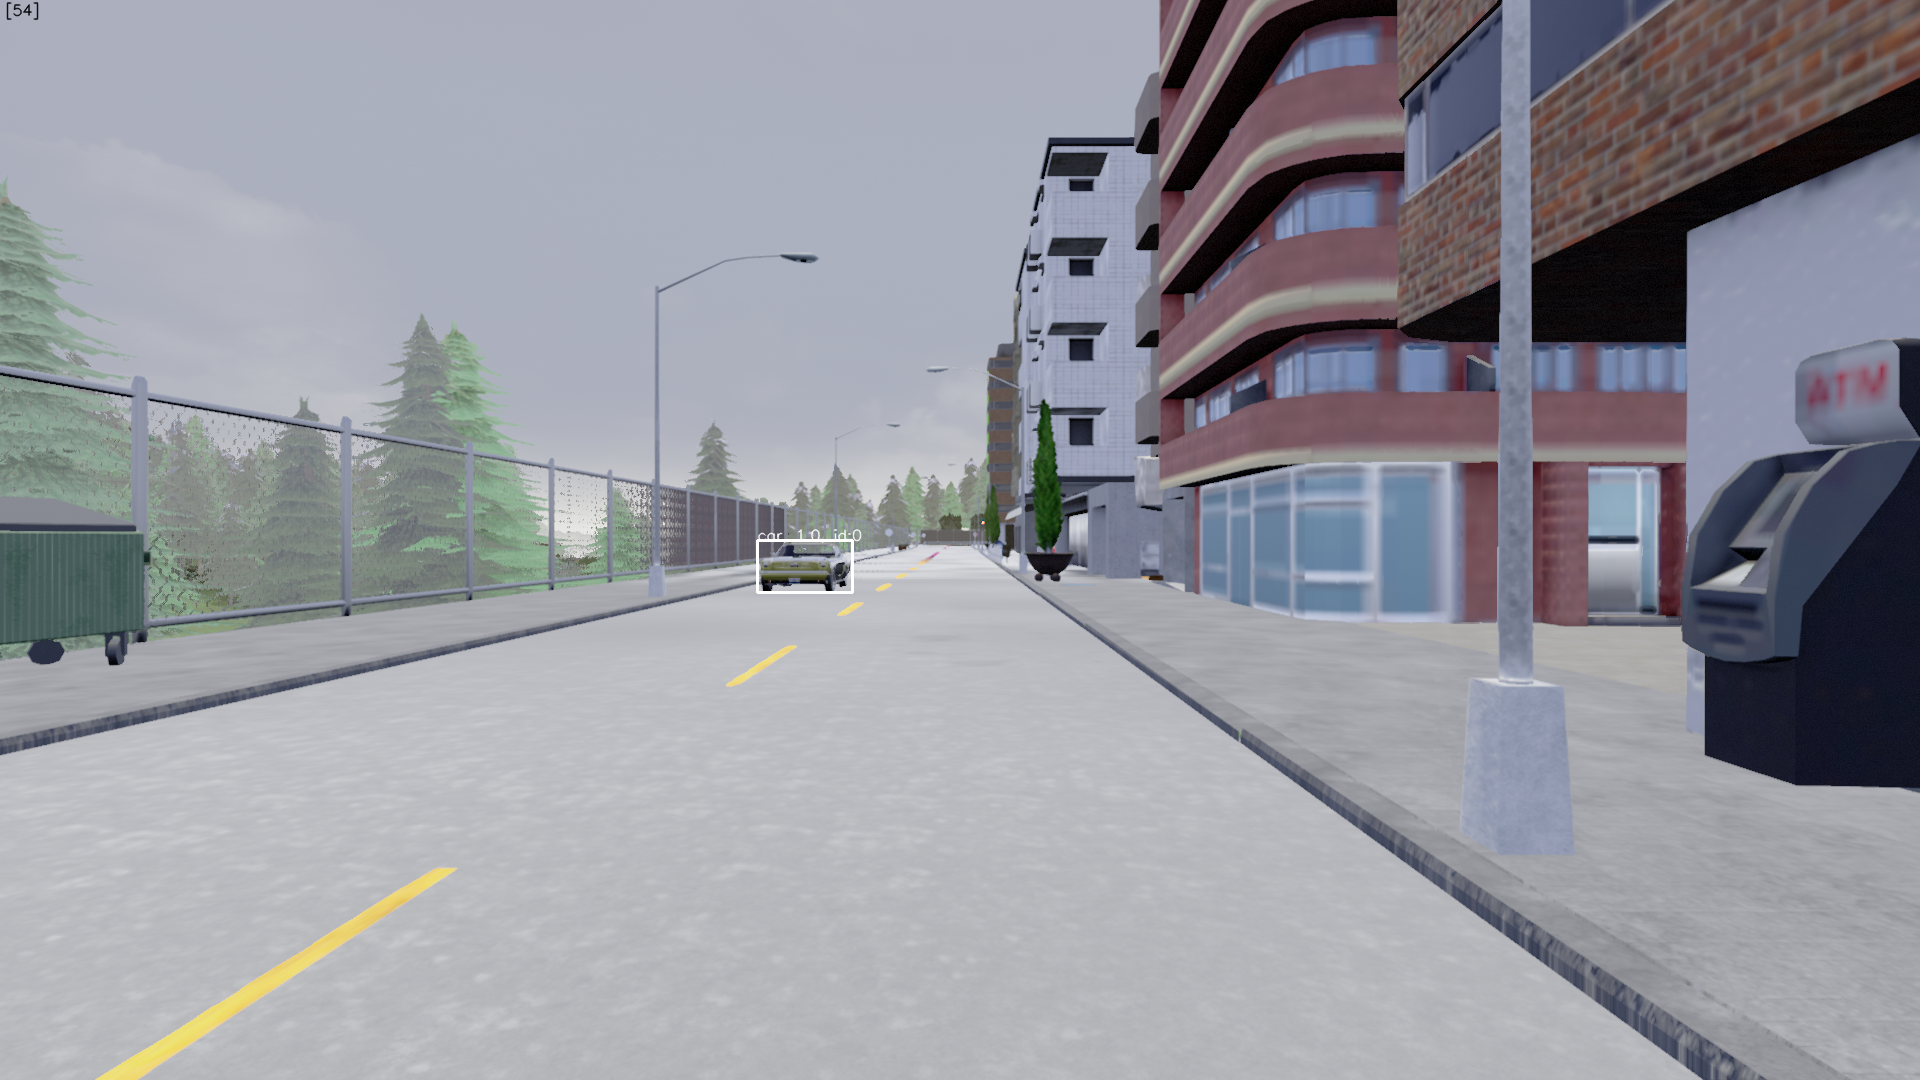

In [3]:
# TODO (1): Uncomment the following line to run the perception component!
erdos.run_async()

# Visualization code, don't change
from pylot.risecamp_utils import visualize_detected_objects
visualize_detected_objects(*visualized_obstacles)